In [ ]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import glob
import zipfile
# flag to decide if run everything or just visualize results
run_all_flag = False

In [ ]:
import freyberg_setup
working_dir = freyberg_setup.WORKING_DIR_KR
pst_name = freyberg_setup.PST_NAME_KR
freyberg_setup.setup_pest_kr()


if not run_all_flag:
    shutil.copy2('sweep.zip',os.path.join(working_dir,'sweep.zip'))
    with zipfile.ZipFile(os.path.join(working_dir,'sweep.zip')) as inzip:
        inzip.extractall(working_dir)

## First read in the PST file and find what are the starting values for K and R

In [ ]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data

In [ ]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.parameter_data.loc['rch_0','partrans']= 'log'
inpst.parameter_data.loc['rch_0','parval1']= 8.0E-1
inpst.parameter_data.loc['hk', 'parval1'] = 12.0
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.0
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name))

In [ ]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name))
os.chdir('..')

In [ ]:
inpst.phi_components

## We can import a function to explore a range of K and R values to make a response surface

In [ ]:
import response_surface as resurf

## First we should write out the control file with new bounds to bracket where values will be explored

## `rch_0` already spans the bounds we want, but `hk` is too wide

In [ ]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = inpst.parameter_data
inpst.parameter_data.loc['hk', 'parval1'] = 12.0
par.loc['hk', 'parlbnd'] = 3
par.loc['hk', 'parubnd'] = 12

inpst.write(os.path.join(working_dir,pst_name))

In [ ]:
inpst.parameter_data

## Run the `run_respsurf` function to calculate the response surface

In [ ]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name)

In [ ]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);

In [35]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data.loc['hk', 'parval1'] = 12.0
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8
inpst.parameter_data.loc['rch_0', 'partrans'] = 'log'
inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name))

In [36]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name))
os.chdir('..')

### Now let's run PEST++ and see what we get for an estimate of the parameters
 * set NOPTMAX=-1
 * run PEST++

In [37]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.ipar')))
pars

,iteration,hk,porosity,rch_0,rch_1
0,0,12,0.01,0.8,1


In [38]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,hk,porosity,rch_0
hk,11375.245243,0.0,-16666.204833
porosity,0.000000,0.0,0.000000
rch_0,-16666.204833,0.0,25082.518274


In [39]:
R = covar.to_pearson()
R.df()

/Users/mnfienen/Documents/GIT/pyemu/pyemu/mat/mat_handler.py:2678: RuntimeWarning: invalid value encountered in double_scalars
  pearson[i,j+i+1] = df.loc[iname,jname] / (std_dict[iname] * std_dict[jname])


,hk,porosity,rch_0
hk,1.000000,NaN,-0.986667
porosity,NaN,1.0,NaN
rch_0,-0.986667,NaN,1.000000


# What if we also have a calibration flux observation?

We can set this up by simply assigning non-zero weight to the observation in the group called `calflux`

We'll read in the PST file, change just that one value and write out a new PST file.

In [40]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [41]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,12.00,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,0.80,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [42]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
###
# Let's fix porosity to avoid getting NaN in our correlation matrices

inpst.parameter_data.loc['porosity','partrans']= 'fixed'

inpst.parameter_data.loc['hk','parval1']= 12.0

inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=10
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))

In [43]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,12.00,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,0.80,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [44]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r1.pst')))
os.chdir('..')

In [45]:
inpst.phi_components

{'calflux': 338670409.0,
 'calhead': 2672.0960051590382,
 'flaqx': 0.0,
 'flout': 0.0,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_storage': 0.0,
 'flx_stream_': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'forecast': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_storage': 0.0,
 'vol_stream_': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [46]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'))

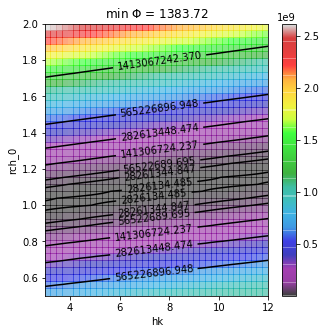

In [47]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'));

In [48]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))

In [49]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r1.pst')))
os.chdir('..')

### We can look at the correlation again

In [50]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r1.ipar')))
pars

,iteration,hk,porosity,rch_0,rch_1
0,0,12,0.01,0.8,1


In [51]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r1.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,hk,rch_0
hk,4.938826e+08,-2.154777e+09
rch_0,-2.154777e+09,9.401249e+09


In [52]:
R = covar.to_pearson()
R.df()

,hk,rch_0
hk,1.000000,-0.999995
rch_0,-0.999995,1.000000


In [53]:
sc.jco.to_dataframe().loc[inpst.nnz_obs_names]

,hk,rch_0
c001cr03c10_19700102,-8.341144,13.071336
c001cr03c16_19700102,-5.892725,10.399249
c001cr04c09_19700102,-8.742295,13.391775
c001cr10c02_19700102,-12.489867,15.747396
c001cr14c11_19700102,-3.105206,7.146753
c001cr16c17_19700102,-0.999819,2.827452
c001cr22c11_19700102,-2.688760,5.163211
c001cr23c16_19700102,-0.205382,1.409753
c001cr25c05_19700102,-7.487278,9.974204
c001cr27c07_19700102,-5.500750,8.084234


## OK - that was bonkers. Maybe a little less weight?

In [ ]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'

inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.001
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))

In [ ]:
inpst.parameter_data


In [ ]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r2.pst')))
os.chdir('..')

In [ ]:
inpst.phi_components

In [ ]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r2.pst'))

In [ ]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r2.pst'));

In [ ]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))

In [ ]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r2.pst')))
os.chdir('..')

## Let's check out correlation again

In [ ]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r2.ipar')))
pars

In [ ]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r2.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

In [ ]:
R = covar.to_pearson()
R.df()

## Can we find a happy medium? Perhaps if we balance the components of the objective function

In [ ]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.025
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))

In [ ]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r3.pst')))
os.chdir('..')

In [ ]:
inpst.phi_components

In [ ]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r3.pst'))

In [ ]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r3.pst'));

In [ ]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 7
inpst.parameter_data.loc['rch_0', 'parval1'] = 1.0
inpst.parameter_data.loc['rch_0', 'parlbnd'] = 0.6


inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))

In [ ]:
os.chdir(working_dir)
pyemu.helpers.run('pestpp {0}'.format(pst_name.replace('.pst','.r3.pst')))
os.chdir('..')

In [ ]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r3.ipar')))
pars

In [ ]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r3.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

In [ ]:
R = covar.to_pearson()
R.df()